In [2]:
# 모듈 호출
import os
import sys
import glob
import shutil
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import mobilenet, mobilenet_v3, MobileNet
from tensorflow.keras.models import Sequential,Model 
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
img_size = 224
channel=3

In [9]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './dataset/train_10',
    batch_size=50,      
    class_mode='categorical', 
    target_size=(img_size, img_size)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './dataset/valid_10',
    batch_size=20,      
    class_mode='categorical', 
    target_size=(img_size, img_size))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './dataset/test_10',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(img_size, img_size),
    shuffle=False)

Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [ ]:
print('train_generator class : ', train_generator.class_indices)
print('valid_generator class : ', valid_generator.class_indices)
print('test_generator class : ', test_generator.class_indices)

train_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}
valid_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}
test_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


### 모델 학습하기 - MobileNet
- 은닉층
    * Dense(224, activation='relu')
- 출력층
    * Dense(10, activation='softmax')
- complie
    * optimizer : adam
    * loss : categorical_crossentropy
    * metrics : accuracy

In [ ]:
# 파라미터 설정
classes = len(train_generator.class_indices)
epochs = 200
batch_size = 32

In [ ]:
MobileNet = MobileNet()
MobileNet.trainable = False # 학습으로 기존 가중치 갱신을 하지 않도록 지정

In [ ]:
# 기본 모델의 아키텍쳐 살펴보기
MobileNet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
model = Sequential()
model.add(MobileNet)
model.add(Dense(224, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1000)             4253864   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 224)               224224    
                                                                 
 dense_1 (Dense)             (None, 10)                2250      
                                                                 
Total params: 4,480,338
Trainable params: 226,474
Non-trainable params: 4,253,864
_________________________________________________________________


In [ ]:
# 모델 환경설정
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
model_name = './model/MobileNet_01_{epoch:02d}-{val_loss:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = model_name,
                                                 save_weights_only=True, 
                                                 save_freq="epoch")
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=200, 
                    epochs=epochs, 
                    validation_data=valid_generator, 
                    validation_steps=40,
                    callbacks = [[earlystop, cp_callback]]) 

Epoch 1/200
200/200 [==============================] - 3535s 18s/step - loss: 2.0748 - accuracy: 0.3537 - val_loss: 1.8321 - val_accuracy: 0.4137
Epoch 2/200
200/200 [==============================] - 313s 2s/step - loss: 1.6510 - accuracy: 0.4642 - val_loss: 1.6016 - val_accuracy: 0.4588
Epoch 3/200
200/200 [==============================] - 137s 687ms/step - loss: 1.4616 - accuracy: 0.5145 - val_loss: 1.4879 - val_accuracy: 0.4950
Epoch 4/200
200/200 [==============================] - 119s 594ms/step - loss: 1.3729 - accuracy: 0.5453 - val_loss: 1.4125 - val_accuracy: 0.4950
Epoch 5/200
200/200 [==============================] - 118s 589ms/step - loss: 1.3015 - accuracy: 0.5639 - val_loss: 1.3815 - val_accuracy: 0.5138
Epoch 6/200
200/200 [==============================] - 120s 602ms/step - loss: 1.2401 - accuracy: 0.5893 - val_loss: 1.2953 - val_accuracy: 0.5575
Epoch 7/200
200/200 [==============================] - 128s 639ms/step - loss: 1.2195 - accuracy: 0.5919 - val_loss: 1.259

### 모델 저장 및 확인

In [ ]:
# 모델 저장
accuracy = round(max(history.history['accuracy'])*100,2)
model.save(f'./model/MobileNet_01_model_ep{epochs}_acc{accuracy}.h5') # 최종 모델 저장

In [5]:
from keras.models import load_model
model = load_model('./MobileNet_01_acc85.0.h5')

In [10]:
model.evaluate(test_generator)

50/50 [==============================] - 339s 7s/step - loss: 0.5674 - accuracy: 0.7980


[0.5673933029174805, 0.7979999780654907]

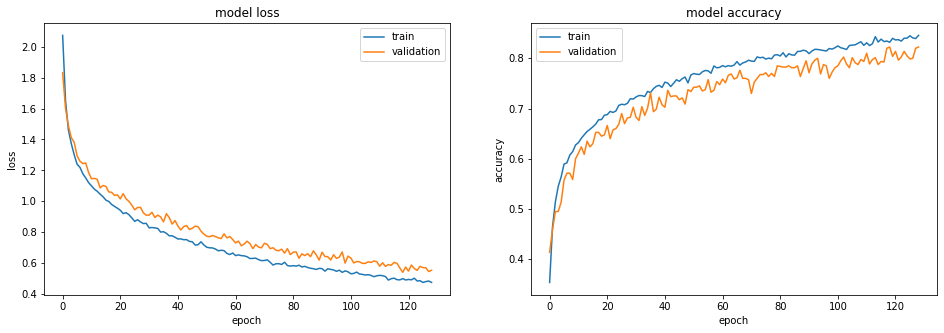

In [ ]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [ ]:
train_generator.class_indices

{'갈아만든배': 0,
 '레쓰비': 1,
 '마운틴듀': 2,
 '밀키스': 3,
 '스프라이트': 4,
 '칠성사이다': 5,
 '코카콜라': 6,
 '트로피카나망고': 7,
 '펩시콜라': 8,
 '환타오렌지': 9}

In [ ]:
test_img = cv2.imread('./Pepsi_cola.jpg')  # 펩시콜라 : 8
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(224,224))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[1.7346998e-03, 4.6902025e-04, 3.2739434e-01, 1.4882920e-02,
        6.0109812e-01, 3.9654979e-03, 8.0637895e-03, 7.9838119e-10,
        4.2382363e-02, 9.2892751e-06]], dtype=float32)

In [ ]:
test_img = cv2.imread('./fanta_orange.jpg')  # 환타오렌지 : 9
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(224,224))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[0.00162187, 0.07932667, 0.09156302, 0.07575079, 0.19662555,
        0.00214532, 0.27638397, 0.03893669, 0.00666576, 0.23098043]],
      dtype=float32)